# Подготавливаем данные

In [1]:
import numpy as np
import pandas as pd
import scipy

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/Applied Statistics"

In [3]:
df = pd.read_csv('data.csv', sep=',')
df.shape

(10000, 7)

In [4]:
df.sample(5)

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
6999,7000,61191.0,1,75000,26,1,0
4441,4442,22926.0,1,28000,19,0,0
4416,4417,78000.0,0,35000,35,0,1
6473,6474,24990.0,0,60000,34,1,0
7990,7991,17052.0,1,40000,30,0,1


* id - идентификатор заявки на получение кредита на товар/услугу
* required_amt - запрошенная сумма кредита
* installment_flg - флаг промо продукта
* monthly_income_amt - ежемесячный доход заявителя
* age - возраст заявителя
* has_high_education_flg - наличие высшего образования
* approved_flg - одобрил ли банк заявку

In [5]:
df.describe()

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
count,10000.00000,9998.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,5000.50000,37806.147129,0.626000,4.654274e+04,32.532200,0.352100,0.261100
std,2886.89568,29479.567128,0.483888,3.622018e+04,11.355345,0.477649,0.439256
min,1.00000,2180.000000,0.000000,2.200000e+01,18.000000,0.000000,0.000000
25%,2500.75000,16990.000000,0.000000,2.800000e+04,24.000000,0.000000,0.000000
50%,5000.50000,27734.500000,1.000000,4.000000e+04,30.000000,0.000000,0.000000
75%,7500.25000,52534.750000,1.000000,5.500000e+04,38.000000,1.000000,1.000000
max,10000.00000,279788.000000,1.000000,1.500000e+06,74.000000,1.000000,1.000000


In [6]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)

In [7]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def get_stat_intervals(stat, alpha):
    '''Для заданной выборки возвращает двусторонний доверительный интервал [aplpha/2, 1 - alpha/2]'''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
# def bucket_estimation(N, sample, app_flag, label):
#     r = np.linspace(sample.min(), sample.quantile(0.99), N + 1)
#     indices = []
#     for i in range(N):
#         for j in range(len(sample)):
#             if sample[j] > r[i] and sample[j] < r[i + 1]:
#                 indices.append(True)
#             else:
#                 indices.append(False)
#     mask = np.reshape(np.array(indices, dtype=bool), (N, len(sample)))
#     res = []
#     for i in range(N):
#         res.append(proportion_confint(app_flag[mask[i]].sum(),
#                                         len(app_flag[mask[i]]),
#                                         alpha = 0.01,
#                                         method = 'wilson'))  
#         print(f'confint 99% predictive interval for {label} {r[i]:,.2f} - {r[i + 1]:,.2f}: [{res[i][0]:,.2f} - {res[i][1]:,.2f}]')
#     return res
# required_amt_confint = bucket_estimation(6, df.required_amt, df.approved_flg, "required_amt")

In [59]:
def bucket_estimation(N, sample, app_flag, label):
    r1 = np.linspace(0, 1, N + 1)
    r = [sample.quantile(x) for x in r1]
    indices = []
    for i in range(N):
        for j in range(len(sample)):
            if sample[j] > r[i] and sample[j] < r[i + 1]:
                indices.append(True)
            else:
                indices.append(False)
    mask = np.reshape(np.array(indices, dtype=bool), (N, len(sample)))
    res = []
    for i in range(N):
        res.append(proportion_confint(app_flag[mask[i]].sum(),
                                        len(app_flag[mask[i]]),
                                        alpha = 0.01,
                                        method = 'wilson'))  
        print(f'confint 99% predictive interval for {label} {r[i]:,.2f} - {r[i + 1]:,.2f}: [{res[i][0]:,.2f} - {res[i][1]:,.2f}]')
    return res

In [79]:
def bucket_visual(sample, intervals, p_title):
#     r = np.linspace(sample.min(), sample.quantile(0.99), len(intervals) + 1)
    r1 = np.linspace(0, 1, len(intervals) + 1)
    r = [sample.quantile(x) for x in r1]
    plt.figure(figsize=(15,10))
    for i in range(len(intervals)):
        pylab.vlines((r[i] + r[i+1]) / 2, intervals[i][0] , intervals[i][1], color='orange')
    pylab.title("Доверительные интервалы для бакетов " + p_title, fontsize=12)
plt.show()

# Домашнее задание

## Задание 1

In [11]:
ln_monthly_income_conf_int = _tconfint_generic(df.monthly_income_amt.apply(lambda x: np.log(x)).mean(),
                                  df.monthly_income_amt.apply(lambda x: np.log(x)).std(ddof=1),
                                  len(df) - 1,
                                  0.05,
                                  'two-sided')

print(f'monthly_income_amt 95% predictive interval: [{np.exp(ln_monthly_income_conf_int[0]):,.2f} - {np.exp(ln_monthly_income_conf_int[1]):,.2f}]')

monthly_income_amt 95% predictive interval: [13,006.90 - 119,867.14]


In [12]:
ln_required_conf_int = _tconfint_generic(df.required_amt.apply(lambda x: np.log(x)).mean(),
                                  df.required_amt.apply(lambda x: np.log(x)).std(ddof=1),
                                  len(df) - 1,
                                  0.05,
                                  'two-sided')

print(f'required_amt 95% predictive interval: [{np.exp(ln_required_conf_int[0]):,.2f} - {np.exp(ln_required_conf_int[1]):,.2f}]')

required_amt 95% predictive interval: [6,676.43 - 124,737.25]


## Задание 2

## Бинарные признаки

### Оценка has_high_education_flg

In [13]:
hh1 = proportion_confint(df[df.has_high_education_flg == 1].approved_flg.sum(),
                        len(df[df.has_high_education_flg == 1].approved_flg),
                        alpha = 0.01,
                        method = 'wilson')
print(f'has_high_education_flg = 1 client 99% predictive interval: [{hh1[0]:,.4f} - {hh1[1]:,.4f}]')

has_high_education_flg = 1 client 99% predictive interval: [0.3074 - 0.3481]


In [14]:
hh0 = proportion_confint(df[df.has_high_education_flg == 0].approved_flg.sum(),
                        len(df[df.has_high_education_flg == 0].approved_flg),
                        alpha = 0.01,
                        method = 'wilson')
print(f'has_high_education_flg = 0 client 99% predictive interval: [{hh0[0]:,.4f} - {hh0[1]:,.4f}]')

has_high_education_flg = 0 client 99% predictive interval: [0.2120 - 0.2387]


Интервалы не пересекаются, но на всякий случай построим интервал для разности долей

In [15]:
hhd = proportions_confint_diff_ind(df[df.has_high_education_flg == 1].approved_flg,
                                   df[df.has_high_education_flg == 0].approved_flg)
print(f'has_high_education_flg difference 99% predictive interval: [{hhd[0]:,.4f} - {hhd[1]:,.4f}]')

has_high_education_flg difference 99% predictive interval: [0.0781 - 0.1268]


### Оценка installment_flg

In [16]:
inst1 = proportion_confint(df[df.installment_flg == 1].approved_flg.sum(),
                            len(df[df.installment_flg == 1].approved_flg),
                            alpha = 0.01,
                            method = 'wilson')
print(f'installment_flg = 1 99% predictive interval: [{inst1[0]:,.4f} - {inst1[1]:,.4f}]')

installment_flg = 1 99% predictive interval: [0.2465 - 0.2751]


In [17]:
inst0 = proportion_confint(df[df.installment_flg == 0].approved_flg.sum(),
                    len(df[df.installment_flg == 0].approved_flg),
                    alpha = 0.01,
                    method = 'wilson')
print(f'installment_flg = 0 for rejected 99% predictive interval: [{inst0[0]:,.4f} - {inst0[1]:,.4f}]')

installment_flg = 0 for rejected 99% predictive interval: [0.2439 - 0.2810]


Интервалы пересекаются, поэтому строим интервал для разности долей

In [18]:
instd = proportions_confint_diff_ind(df[df.installment_flg == 1].approved_flg,
                             df[df.installment_flg == 0].approved_flg)
print(f'installment_flg difference 99% predictive interval: [{instd[0]:,.4f} - {instd[1]:,.4f}]')

installment_flg difference 99% predictive interval: [-0.0249 - 0.0219]


## Вещественные признаки

### Оценка required_amt

confint 99% predictive interval for required_amt 2,180.00 - 10,705.42: [0.30 - 0.38]
confint 99% predictive interval for required_amt 10,705.42 - 13,978.00: [0.32 - 0.41]
confint 99% predictive interval for required_amt 13,978.00 - 16,990.00: [0.30 - 0.38]
confint 99% predictive interval for required_amt 16,990.00 - 20,000.00: [0.26 - 0.34]
confint 99% predictive interval for required_amt 20,000.00 - 23,391.00: [0.24 - 0.33]
confint 99% predictive interval for required_amt 23,391.00 - 27,734.50: [0.25 - 0.33]
confint 99% predictive interval for required_amt 27,734.50 - 33,665.17: [0.26 - 0.34]
confint 99% predictive interval for required_amt 33,665.17 - 41,773.67: [0.22 - 0.30]
confint 99% predictive interval for required_amt 41,773.67 - 52,534.75: [0.17 - 0.24]
confint 99% predictive interval for required_amt 52,534.75 - 62,382.50: [0.13 - 0.20]
confint 99% predictive interval for required_amt 62,382.50 - 80,287.50: [0.15 - 0.21]
confint 99% predictive interval for required_amt 80,287

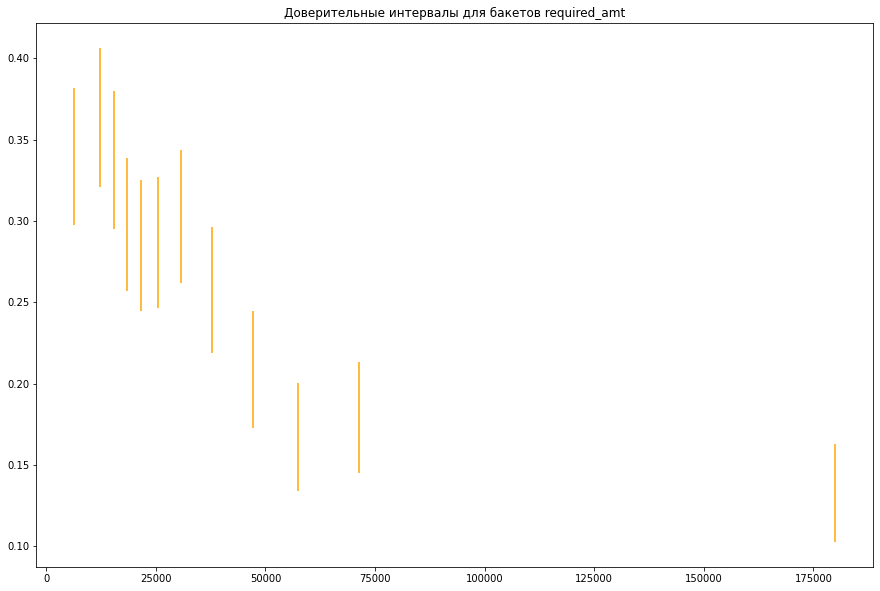

In [88]:
required_amt_confint = bucket_estimation(12, df.required_amt, df.approved_flg, "required_amt")
bucket_visual(df.required_amt, required_amt_confint, "required_amt")

Данный признак разделяет риски, это видно на графике: с увеличением запрашиваемой суммы вероятность одобрения падает (ну и это достаточно логично).

В случае разбиения на 2 или 3 бакета доверительные интервалы даже не пересекаются, что подтверждает сказанное выше (для проверки можно изменить количество блоков с помощью первого аргумента функции bucket_estimation)

### Оценка monthly_income_amt

confint 99% predictive interval for monthly_income_amt 22.00 - 25,000.00: [0.25 - 0.32]
confint 99% predictive interval for monthly_income_amt 25,000.00 - 30,000.00: [0.17 - 0.27]
confint 99% predictive interval for monthly_income_amt 30,000.00 - 35,000.00: [0.16 - 0.28]
confint 99% predictive interval for monthly_income_amt 35,000.00 - 42,000.00: [0.24 - 0.31]
confint 99% predictive interval for monthly_income_amt 42,000.00 - 50,000.00: [0.20 - 0.27]
confint 99% predictive interval for monthly_income_amt 50,000.00 - 70,000.00: [0.20 - 0.26]
confint 99% predictive interval for monthly_income_amt 70,000.00 - 1,500,000.00: [0.24 - 0.31]


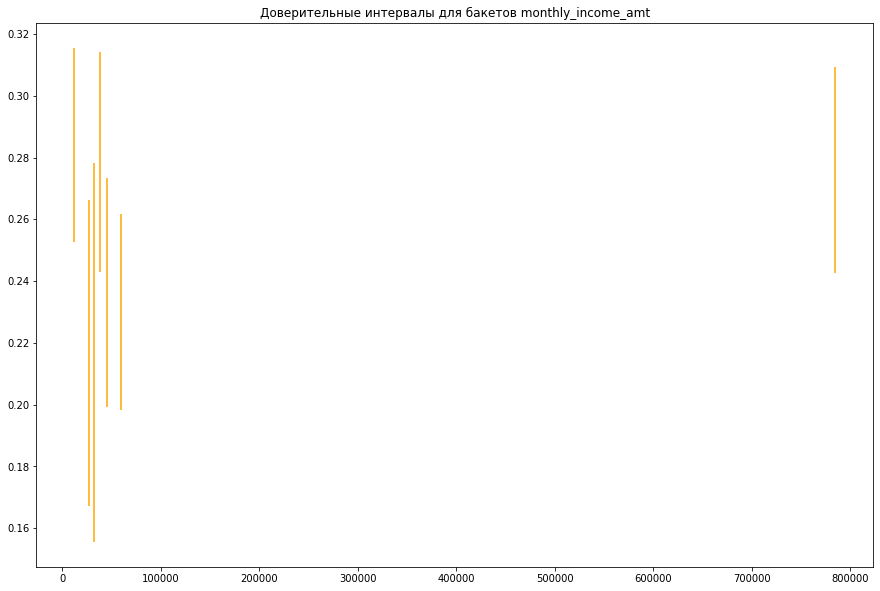

In [94]:
monthly_income_amt_confint = bucket_estimation(12, df.monthly_income_amt, df.approved_flg, "monthly_income_amt")
bucket_visual(df.monthly_income_amt, monthly_income_amt_confint, "monthly_income_amt")

Данный признак не разделяет риски, это видно на графике: на всей области значений интервалы пересекаются и находятся примерно на одном уровне, закон поведения их расположения не зависит от значения з/п.

В случае разбиения на 2 или 3 бакета доверительные интервалы достаточно сильно пересекаются и находятся примерно на одном уровне, что подтверждает сказанное выше (для проверки можно изменить количество блоков с помощью первого аргумента функции bucket_estimation)

### Оценка age

confint 99% predictive interval for age 18.00 - 23.00: [0.08 - 0.11]
confint 99% predictive interval for age 23.00 - 27.00: [0.18 - 0.23]
confint 99% predictive interval for age 27.00 - 33.00: [0.26 - 0.31]
confint 99% predictive interval for age 33.00 - 41.00: [0.30 - 0.36]
confint 99% predictive interval for age 41.00 - 74.00: [0.39 - 0.44]


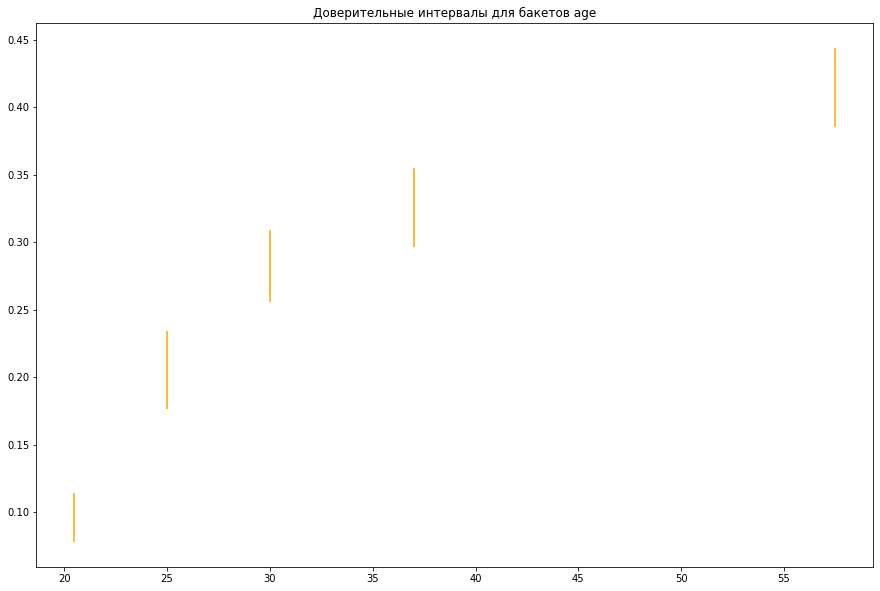

In [98]:
age_confint = bucket_estimation(5, df.age, df.approved_flg, "age")
bucket_visual(df.age, age_confint, "age")

Данный признак разделяет риски, это видно на графике: с увеличением возраста вероятность одобрения возрастает (ну и это достаточно логично).

В случае разбиения на 2-4 бакета доверительные интервалы даже не пересекаются, что подтверждает сказанное выше (для проверки можно изменить количество блоков с помощью первого аргумента функции bucket_estimation)

## Задание 3

In [22]:
np.random.seed(0)

def odds(x):
    return (x.sum() / len(x)) / (1 - (x.sum() / len(x)))

In [23]:
df['domination'] = (df['required_amt'] < df['monthly_income_amt']).apply(lambda x: int(x))
df.sample(5)

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg,domination
9394,9395,13659.0,0,40000,22,1,0,1
898,899,44991.0,1,65000,27,0,0,1
2398,2399,5559.0,1,175000,38,1,1,1
5906,5907,21821.0,1,30000,19,0,0,1
2343,2344,47492.0,1,50000,20,0,0,1


### Точечная оценка

In [24]:
print(f'dominator client odds = {odds(df[df.domination == 1].approved_flg.values)}')
print(f'slave client odds = {odds(df[df.domination == 0].approved_flg.values)}')

dominator client odds = 0.43467829880043624
slave client odds = 0.22039942938659057


### Интервальная оценка

In [25]:
dom_odds_scores = list(map(odds, get_bootstrap_samples(df[df.domination == 1].approved_flg.values, 10000)))
slav_odds_scores = list(map(odds, get_bootstrap_samples(df[df.domination == 0].approved_flg.values, 10000)))

print('dominator client 99% confidence interval:',  get_stat_intervals(dom_odds_scores, 0.01))
print('slave:) client 99% confidence interval:',  get_stat_intervals(slav_odds_scores, 0.01))

dominator client 99% confidence interval: [0.40645713 0.46601293]
slave:) client 99% confidence interval: [0.19566737 0.24708455]


### Оценка отношения точечно и интервально

In [26]:
rel_odds_scores = list(map(lambda x: x[0] / x[1], zip(dom_odds_scores, slav_odds_scores)))
print(f'Avg odds ratio: {sum(rel_odds_scores) / len(rel_odds_scores) :.2f}')

Avg odds ratio: 1.97


In [27]:
print('99% confidence interval for the ratio between odds',  get_stat_intervals(rel_odds_scores, 0.01))

99% confidence interval for the ratio between odds [1.72793212 2.2491006 ]
